# Entry 15 notebook - Categorical Correlation/Collinearity - Solar Flare Dataset

Categorical collinearity using the [Solar Flare Dataset](http://archive.ics.uci.edu/ml/datasets/Solar+Flare) on the UCI Repository.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

import category_encoders as ce
import scipy.stats as ss
import math
from collections import Counter

### Functions

In [2]:
def drop_undifferentiated(df):
    drop_cols = []
    for col in df.columns:
        if len(df[col].unique()) == 1:
            drop_cols.append(col)
    df = df.drop(drop_cols, axis=1)
    return df

In [14]:
def p_and_s_corrs(df, encoder=ce.OrdinalEncoder):
    cat_cols = df.columns.tolist()
    index = df.index.tolist()
    encoder = encoder(cols=cat_cols)
    encd_df = pd.DataFrame(encoder.fit_transform(df[cat_cols]), index=index)
    encd_df = drop_undifferentiated(encd_df)
    
    pearson = encd_df.corr()
    spearman = encd_df.corr(method='spearman')
    return pearson, spearman

def viz_double_heatmap(df1, name1, df2, name2, vmin=-1, vmax=1, annot=False):
    plt.figure(figsize=(20,7))
    plt.subplot(1, 2, 1)
    sns.heatmap(df1, vmin=vmin, vmax=vmax, annot=annot)
    plt.title(name1 + ' correlations')
    
    plt.subplot(1, 2, 2)
    sns.heatmap(df2, vmin=vmin, vmax=vmax, annot=annot)
    plt.title(name2 + ' correlations')
    
    plt.show()

In [4]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def cramers_df(df):
    cramers = pd.DataFrame()
    for i, a in enumerate(df.columns):
        cramers.loc[a, a] = 1.0
        for b in df.columns[:i]:
            val = round(cramers_v(df[a], df[b]), 2)
            cramers.loc[a,b] = val
            cramers.loc[b,a] = val
    return cramers

In [5]:
def conditional_entropy(x, y):
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x, y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y / p_xy)
    return entropy

def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x
    
def theils_df(df):
    theil = pd.DataFrame()
    for i, a in enumerate(df.columns):
        theil.loc[a, a] = 1.0
        for b in df.columns:
            theil.loc[a,b] = round(theils_u(df[b], df[a]), 2)
            theil.loc[b,a] = round(theils_u(df[a], df[b]), 2)
    return theil

### Data

In [6]:
col_names = ['class', 'spot_size', 'spot_distro', 'activity', 'evolution', 'flare_activity', 'historically_complex',
'became_complex', 'area', 'spot_area', 'c_class_flares', 'm_class_flares', 'x_class_flares']

df69_raw = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/solar-flare/flare.data1',
                     header=None, skiprows=1, sep=' ',
                     names=col_names).drop(['c_class_flares', 'm_class_flares', 'x_class_flares'], axis=1)
df78_raw = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/solar-flare/flare.data2',
                     header=None, skiprows=1, sep=' ',
                     names=col_names).drop(['c_class_flares', 'm_class_flares', 'x_class_flares'], axis=1)
df_raw = pd.concat([df69_raw, df78_raw])
df_raw.head()

,class,spot_size,spot_distro,activity,evolution,flare_activity,historically_complex,became_complex,area,spot_area
0,C,S,O,1,2,1,1,2,1,2
1,D,S,O,1,3,1,1,2,1,2
2,C,S,O,1,3,1,1,2,1,1
3,D,S,O,1,3,1,1,2,1,2
4,D,A,O,1,3,1,1,2,1,2


In [7]:
# target = 'class'
        
# df_y = df_raw[target].astype('category').cat.rename_categories({'EDIBLE':1, 'POISONOUS':0})
# df = df_raw.drop(target, axis=1)
df = drop_undifferentiated(df_raw)
df.tail()

,class,spot_size,spot_distro,activity,evolution,flare_activity,historically_complex,became_complex,area,spot_area
1061,H,S,X,1,2,1,1,1,1,1
1062,H,S,X,2,2,1,1,2,1,1
1063,C,S,O,1,2,1,2,2,1,1
1064,H,R,X,1,2,1,1,2,1,1
1065,B,X,O,1,1,1,1,2,1,1


### Pearson and Spearman correlations with encoding

In [8]:
target_indepnt = [ce.OrdinalEncoder, ce.OneHotEncoder, ce.BinaryEncoder, ce.HashingEncoder,
                  ce.BackwardDifferenceEncoder, ce.HelmertEncoder, ce.PolynomialEncoder, ce.SumEncoder]
target_depnt = [ce.CatBoostEncoder, ce.JamesSteinEncoder, ce.LeaveOneOutEncoder,
                ce.MEstimateEncoder, ce.TargetEncoder, ce.WOEEncoder]

<class 'category_encoders.ordinal.OrdinalEncoder'>


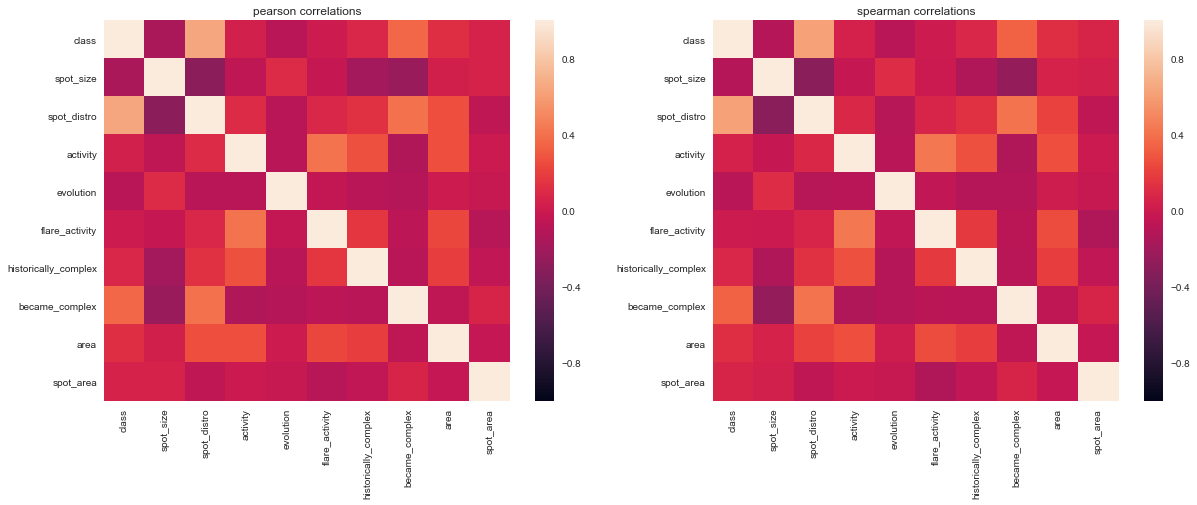



<class 'category_encoders.one_hot.OneHotEncoder'>


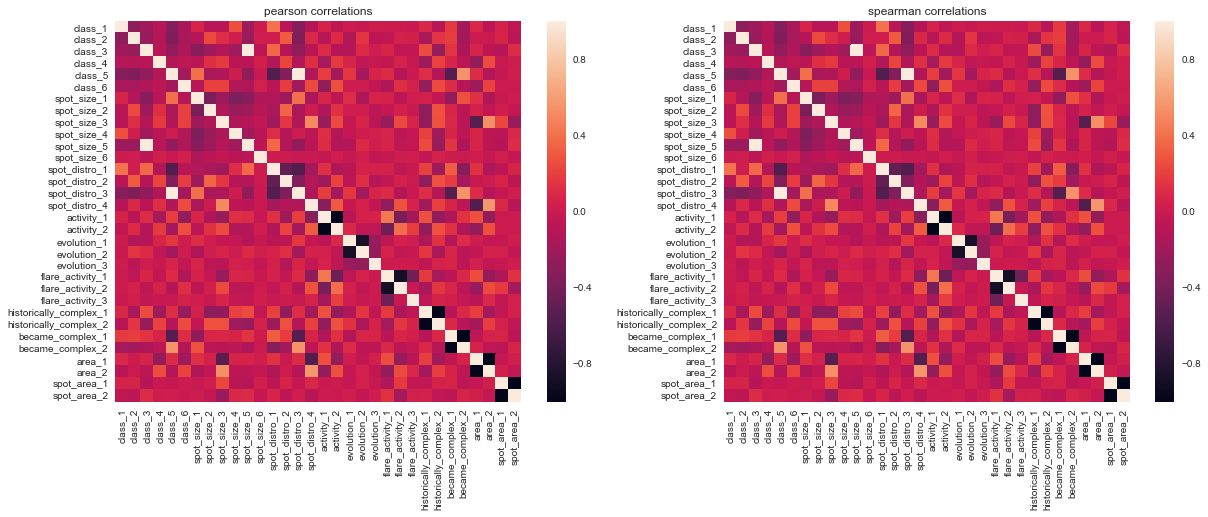



<class 'category_encoders.binary.BinaryEncoder'>


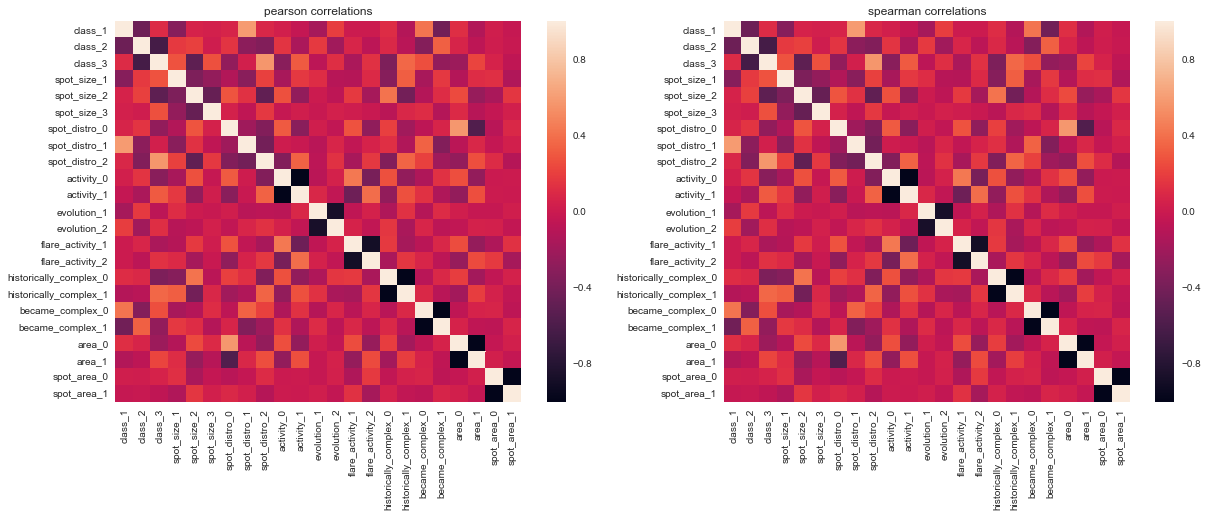



<class 'category_encoders.hashing.HashingEncoder'>


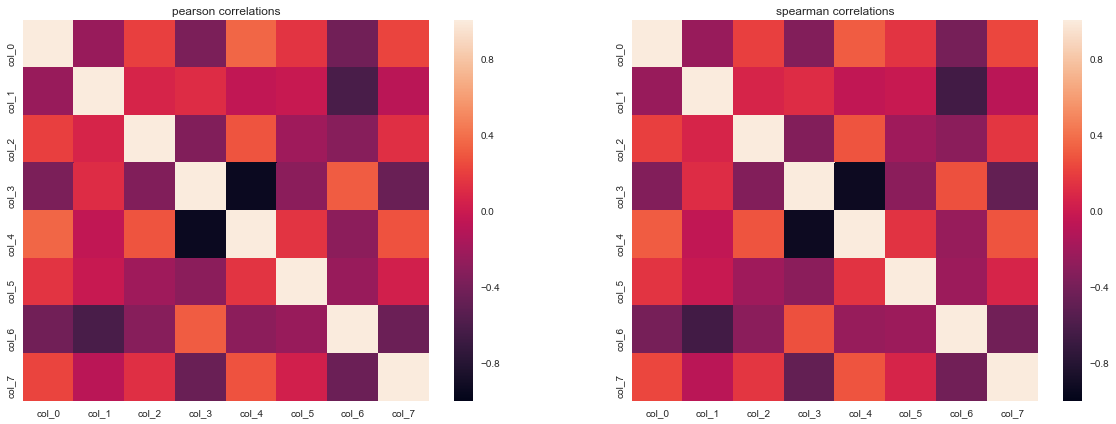



<class 'category_encoders.backward_difference.BackwardDifferenceEncoder'>


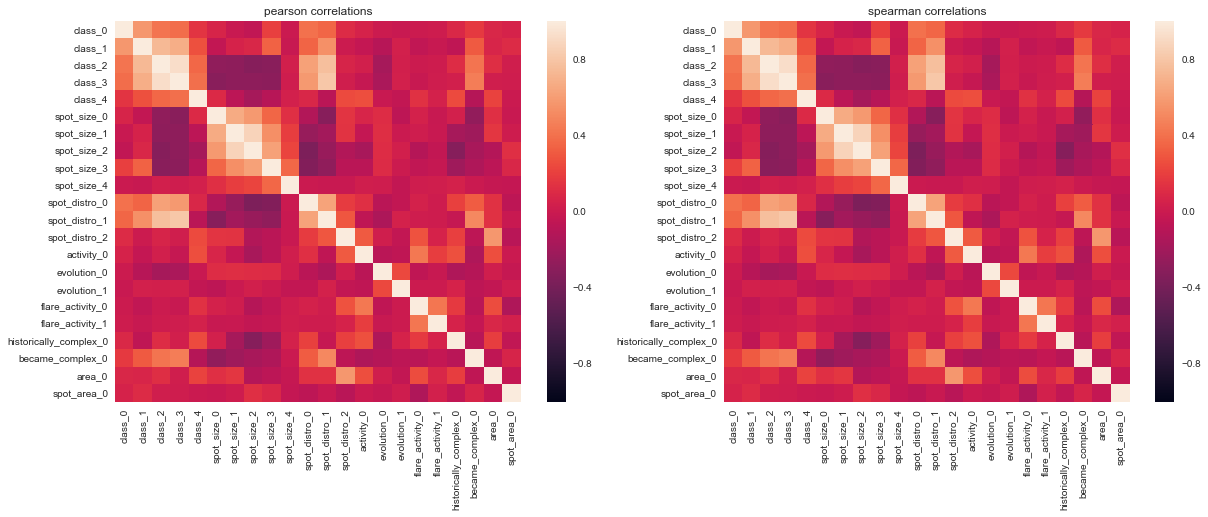



<class 'category_encoders.helmert.HelmertEncoder'>


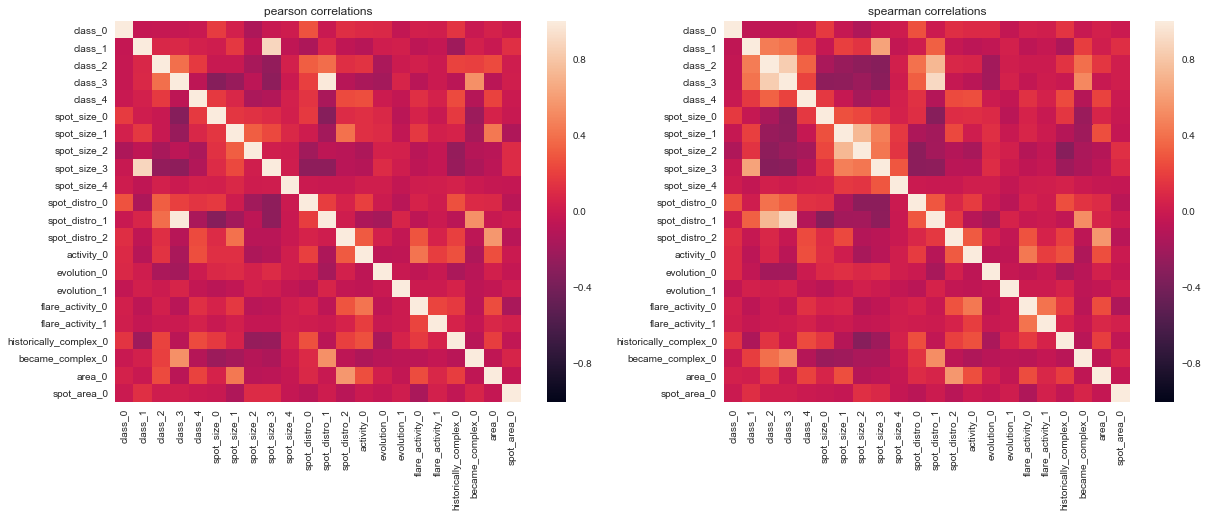



<class 'category_encoders.polynomial.PolynomialEncoder'>


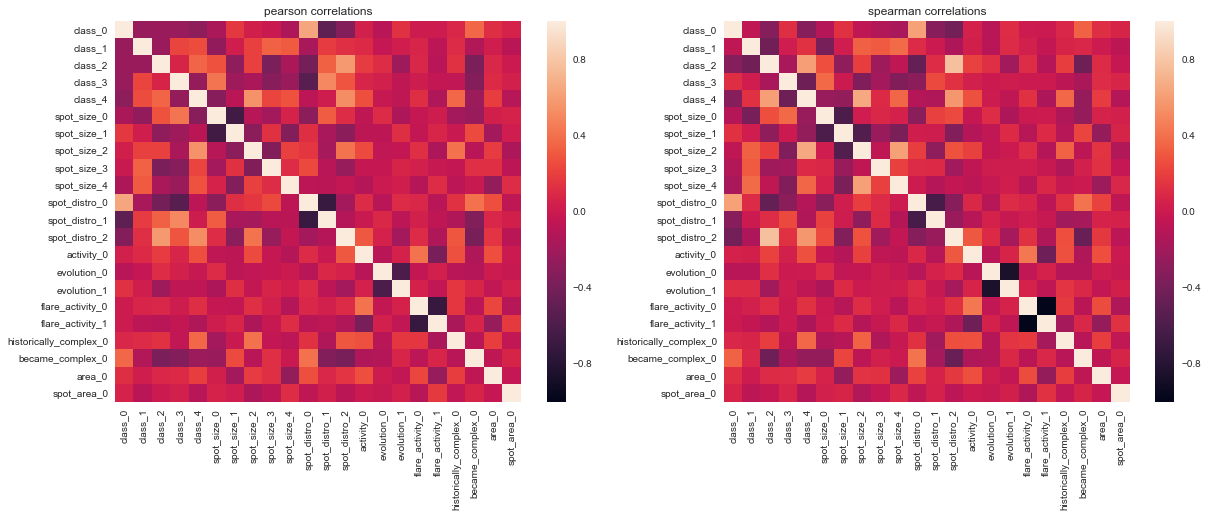



<class 'category_encoders.sum_coding.SumEncoder'>


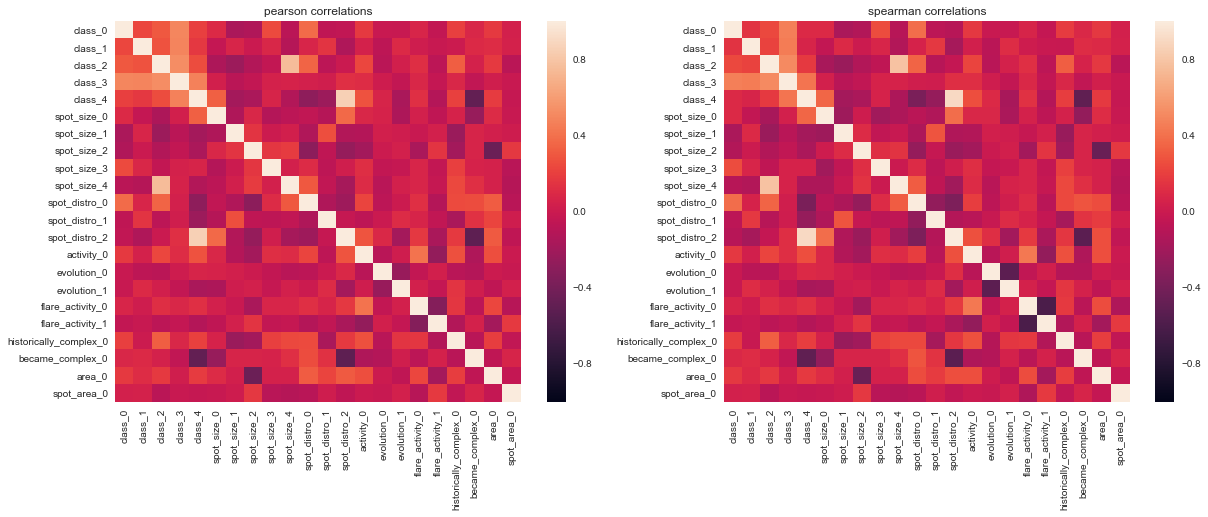

In [9]:
for encoder in target_indepnt:
    print(str(encoder))
    pearson, spearman = p_and_s_corrs(df, encoder=encoder)
    viz_double_heatmap(pearson, 'pearson', spearman, 'spearman')
    print('\n')

### Cramer's V and Theil's U

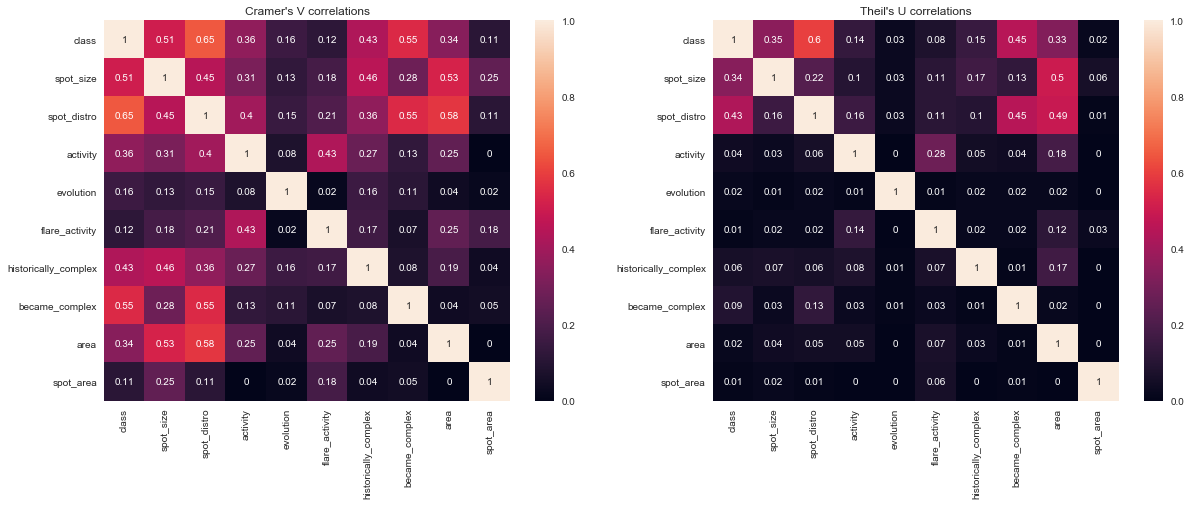

In [15]:
cramers = cramers_df(df)
theils = theils_df(df)
viz_double_heatmap(cramers, "Cramer's V", theils, "Theil's U", vmin=0, annot=True)